# Correlations with the Climate indices <br>

This notebook computes the correlations between the climate indices: MEIv2, PDO, NPGO and the fraction of extremse. I will implement block bootstrapping. To determine how big the block size should be we consider the time series. For the ocean variables we want to preserve the seasonal cycle so an minimum block size of 12 months is appropriate. To determine how big of a block we needed, we plotted the autocorraltion for each of the indices. Most of the indices have a near-zero correlation after the first lag, but the NPGO doesn't approach near-zero values until about 36 months. Thus, we choose 12 months for all of the indices except for the NPGO. 

In [24]:
import xarray as xr
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from statsmodels.tsa.stattools import acf
import scipy.stats as ss
import seaborn as sns
import matplotlib
import datetime
import pickle
import pandas as pd
import itertools
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors =itertools.cycle(plt.get_cmap('magma')(np.linspace(0.25,0.75, 3)))
colorA=next(colors)

colorC=next(colors)
colorB=next(colors)
#import basemap
#fig sizes
Wf=(190/25.4)
Hf=(230/25.4)
Wf4=(95/25.4)
Hf4=(115/25.4)

color1='#00CD6C'#green
color2='#AF58BA'#purple
color3='#FFC61E' #yello
color4='#009ADE' #blue
color5='#F28522' #orange
color6='#A0B1BA' #gray
color7='#A6761D'#brown
color8='#FF1F5B' #red

In [25]:
print(sns.__version__)
#mymap=sns.choose_diverging_palette(as_cmap=False)
mymap=sns.choose_colorbrewer_palette('diverging', as_cmap=False)


0.13.2


interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

In [26]:
cluster_data_path = '/home/amh001/space_fs7/DATA/NEP36-CanOE/'
clusters_ds=[]
for ii in range(6):
    cluster_files = sorted(glob.glob(f'{cluster_data_path}/From_Andrew/processed/daily/by_year/by_cluster/n_clusters_6/cluster_{ii}*.nc')) 
    #print(cluster_files    )
    cluster_ds =xr.open_mfdataset(cluster_files, chunks={'time':439}, engine='h5netcdf')
    clusters_ds.append(cluster_ds)

In [27]:
hist_kwargs = {
    'alpha':1,
    'density':True,
    'bins':25,
    'edgecolor':'None'
}

In [28]:
plot_clusters = [3, 0]
cluster_names = {3:'Shallows', 0:'Canyons'}

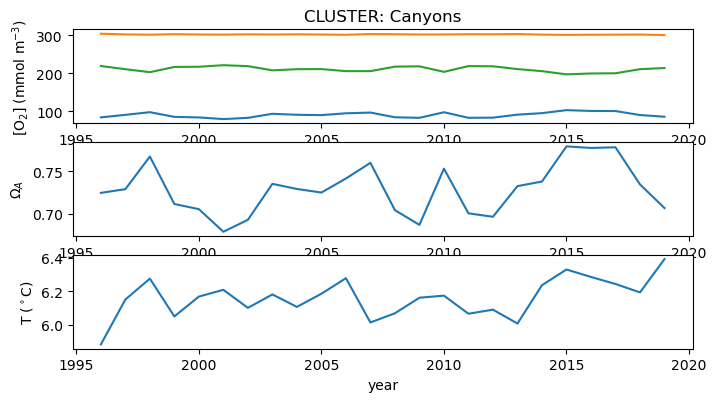

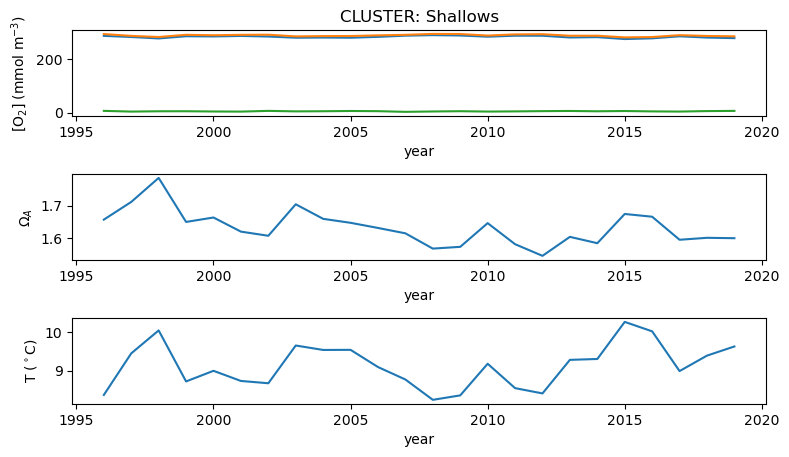

In [29]:
# Plot timeseries of all the relevant variables

timeseries_vars = [
    'O2',
    'OmegaA',
    'T',
    # 'ALK_norm',
    # 'DIC_norm',
    # 'ALK',
    # 'DIC',
]


long_names = dict(
    O2=r"$[\mathrm{O}_2]$",
    OmegaA="$\Omega_A$",
    T="T"
    # ALK_norm="Normalized Alkalinity",
    # DIC_norm="Normalized DIC",
    # ALK="Alkalinity",
    # DIC="DIC",
)

units = dict(
    O2="mmol m$^{-3}$",
    OmegaA="(non-dimensional)",
    T="$^\circ$C",
    
    # ALK_norm="mmolk m$^{-3}$",
    # DIC_norm="mmolk m$^{-3}$",
    # ALK="mmolk m$^{-3}$",
    # DIC="mmolk m$^{-3}$"
)


for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        plt.figure(figsize=(8,10))    
        for idx, var in enumerate(timeseries_vars):        
            plt.subplot(7,1,idx+1)
            cluster_ds[var].groupby('time.year').mean('time').mean('stacked_y_x').plot()
            if var =='O2':
                (cluster_ds[var].groupby('time.year').mean('time').mean('stacked_y_x')+cluster_ds['AOU'].groupby('time.year').mean('time').mean('stacked_y_x')).plot()
                cluster_ds['AOU'].groupby('time.year').mean('time').mean('stacked_y_x').plot()
            if var=='OmegaA':
                plt.ylabel(f"{long_names[var]}")
            else:
                plt.ylabel(f"{long_names[var]} ({units[var]})")
            if idx == 0:
                plt.title(f'CLUSTER: '+ cluster_names[cluster_label])# {cluster_label}')
            else:
                plt.title('')
plt.tight_layout()   

### Correlations
Now, lets create look at the correlations between these time series and MEIv2 - the ENSO index. 

In [30]:
#load MEIv2
data=[]; count=0
with open('/gpfs/fs7/dfo/hpcmc/pfm/amh001/DATA/Climate-Indices/meiv2.data') as f:
    for line in f.readlines():
        l1=line.strip()
        l2=l1.split()
        try:
            #print(l2)
            year=int(l2[0])
            #print(year)
            if (year >1995) & (year<2020):
                #print(year)
                count=count+1
                dat=[float(num) for num in l2[1:]]
                #print(len(dat))
                
                data.extend(dat)
        except:
            print('exception', l2)
data =np.array(data)
dates=np.array(pd.date_range(start="1996-01-01",end="2019-12-01", freq=pd.DateOffset(months=1)))
# we use the beginning of the month because they are 2 month averages
#print(np.shape(data),np.shape(dates), dates[-1], dates[0], 12*(2020-1996))#

exception ['-999.00']
exception ['Multivariate', 'ENSO', 'Index', 'Version', '2', '(MEI.v2)']
exception ['https://www.psl.noaa.gov/enso/mei']
exception ['Row', 'values', 'are', '2', 'month', 'seasons', '(YEAR', 'DJ', 'JF', 'FM', 'MA', 'AM', 'MJ', 'JJ', 'JA', 'AS', 'SO', 'ON', 'ND)']


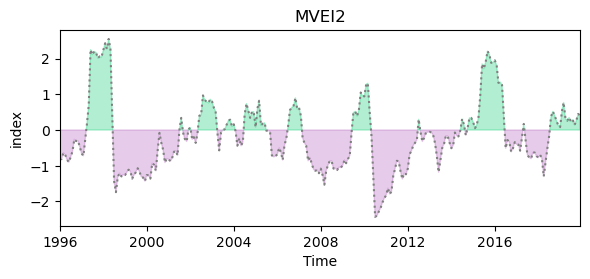

In [31]:
fig1=plt.figure(figsize=(6,5))
ax1=fig1.add_subplot(212)
plt.title('MVEI2')

plt.plot( dates,data, color='0.5', linestyle=':')
ax1.fill_between( dates,data,np.zeros(len(data)),where= data<0,color=color2, alpha=0.3, interpolate=True)
ax1.fill_between( dates,data,np.zeros(len(data)),where= data>0,color=color1, alpha=0.3, interpolate=True)
plt.ylabel('index')
plt.xlabel('Time')
plt.xlim(min(dates), max(dates))
#ax1.fill_betweenx( -depth,np.ones(75)*num*kk,newV,where=V[kk,:]<=0,color=color4, alpha=0.3, interpolate=True)
plt.tight_layout()

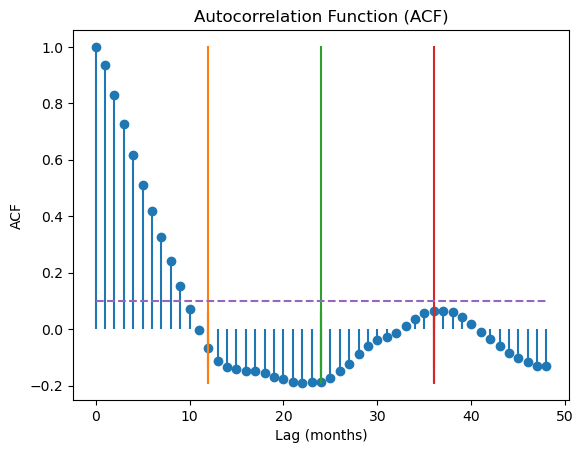

In [32]:

n=48
# Example monthly data for 24 years (288 months)

# Compute autocorrelations
acf_values = acf(data, nlags=n)  # Look at up to 24 lags (2 years)

# Plot autocorrelation
plt.stem(range(n+1), acf_values[:n+1], basefmt=" ")
plt.plot(12*np.ones(n+1), acf_values[:n+1])
plt.plot(24*np.ones(n+1), acf_values[:n+1])
plt.plot(36*np.ones(n+1), acf_values[:n+1])
plt.plot(range(n+1),0.1*np.ones(n+1), '--')

plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag (months)')
plt.ylabel('ACF')
plt.show()


## Shallows

In [33]:
def deseason(df):
    monthly=df.resample(time='1MS').mean()
    #data_month = df.resample('M', on=df.index).mean()
    seas=df.groupby('time.month').mean()
    monthly_des=monthly.values

    num=12
    #print(monthly_des.shape, seas.shape)
    ii0=0
    ii=12
    while ii <=len(monthly):  
        #print(ii0, ii)
        monthly_des[ii0:ii]=monthly_des[ii0:ii]-seas.values
        ii0=ii
        ii=ii+12
    monthly_des[-1]=monthly_des[-1]-seas.values[0]
    print(monthly)
    return monthly_des, monthly.time

Originally, I was using efcetive sample size. But this can give a very small sample size.  Note that it is based on autocorrelation, but only considers the first lag. I will try to modify it to consider all lags and see how it changes my confidence interval .

In [34]:
def block_bootstrap(x, y, block_size, n_iterations):
    n = len(x)
    ci_low, ci_high = [], []

    for _ in range(n_iterations):
        # Sample indices for the blocks
        block_indices = np.random.choice(n - block_size, size=n // block_size, replace=True)

        # Resample the blocks for both signals simultaneously
        x_resampled, y_resampled = [], []
        for idx in block_indices:
            x_resampled.append(x[idx: idx + block_size])
            y_resampled.append(y[idx: idx + block_size])

        # Concatenate the blocks and truncate to match the original length
        x_resampled = np.concatenate(x_resampled)[:n]
        y_resampled = np.concatenate(y_resampled)[:n]

        # Calculate the correlation coefficient for this bootstrap sample
        correlation = np.corrcoef(x_resampled, y_resampled)[0, 1]
        
        # Collect the correlation values for CI calculation
        ci_low.append(correlation)
        ci_high.append(correlation)

    # Calculate the 95% CI from the bootstrap samples
    ci_low = np.percentile(ci_low, 2.5)
    ci_high = np.percentile(ci_high, 97.5)

    return ci_low, ci_high


def plot_correlations(sig1,sig2,t0,nTime,label, index, block_size):
    alpha=0.05 # %95 confidence interval
    nsig1 = sig1 - np.mean(sig1) # Demean sig1
    nsig2 = sig2 - np.mean(sig2) # Demean
    ccov = np.correlate(nsig1, nsig2, mode='full')
    ccor = ccov / (len(sig2) * np.std(sig1) * np.std(sig2))
    #print(ccor)
    nx=len(sig1)
    lags = np.arange(-nx + 1, nx) # so last value is nx - 1
    ################
    fig=plt.figure(figsize=(6,5))
    ax = fig.add_subplot(311)
    #ax.plot(t0, nsig1, 'b', label='obs')
    print(np.nanmax(sig1), np.nanmax(sig2))
    #.plot( dates,data, color='0.5', linestyle=':')
    ax.fill_between( t0, sig2,np.zeros(len(sig2)),where= sig2<0,color=color2, alpha=0.3, interpolate=True)
    ax.fill_between( t0, sig2,np.zeros(len(sig2)),where= sig2>0,color=color1, alpha=0.3, interpolate=True)
    ax.plot(t0, sig2, color='0.5', label=label)
    ax.set_ylabel(label, labelpad=15)
    ax.set_xlabel('Time (years)')
    plt.xlim([1996, 2020]) 
 
    #ax.set_ylim(-10, 10)
    #ax.legend(loc='upper right', fontsize='small', ncol=2)
    ax = fig.add_subplot(312)
    ax.fill_between( nTime, sig1,np.zeros(len(sig1)),where= sig1<0,color=color2, alpha=0.3, interpolate=True)
    ax.fill_between( nTime, sig1,np.zeros(len(sig1)),where= sig1>0,color=color1, alpha=0.3, interpolate=True)
    ax.plot(nTime, sig1, color='0.5', label=label)

    #plt.xlim([nTime[0], nTime[-1]])
    #ax.plot(nTime, sig1, color=color2, label='NEP36')
    ax.set_ylabel(index, labelpad=15)
    ax.set_xlabel('Time (years)')
    plt.xlim([1996, 2020]) 
    #ax.plot(t0, nsig2, 'r', label='PDO')
    #ax.set_ylim(-10, 10)
    #ax.legend(loc='upper right', fontsize='small', ncol=2)
    ax = fig.add_subplot(313)
    ax.plot(lags, ccor)
    #ax.plot(lags[len(sig1)], ccor[len(sig1)], 'ro')
    ax.annotate( 'corr= '+str(round(ccor[len(sig1)-1],2)),(-250,.23))# (lags[len(sig1)-1], 0))
    #ax.set_ylim(-1.1, 1.1)
    ax.set_ylabel('cross-correlation')
    ax.set_xlabel('lag (months)')
    plt.xlim([-18, 18])

    maxlag = lags[np.argmax(ccor)]
    minlag = lags[np.argmin(ccor)]
    maxcorr=np.max(ccor)
    
    print("max correlation is at lag %d" % maxlag, "with r = %f" % maxcorr)

    print("min correlation is at lag %d" % minlag , "with r = %f" % np.min(ccor))
    plt.tight_layout()
    lo,hi = block_bootstrap(nsig1,nsig2, block_size, 5000)
    # Calculate observed correlation
    obs_corr = np.corrcoef(nsig1,nsig2)[0, 1]

    if lo*hi < 0.0:
        print('Probably independent based on pearson')
    else:
        print('Probably dependent based on pearson')
        
    print('With', 100*(1-alpha), '% confidence, the time series correlation is between ', lo, hi)   
    return obs_corr,lo,hi

In [35]:
dates_1d=np.array(pd.date_range(start="1996-01-01",end="2019-12-31", freq='1D'))
print(np.shape(dates_1d))

(8766,)


In [36]:
#set the times according to the decimal time. 
t0 = 1996#1997.0
dt = 1/12  # In years
N = len(data)
ts = np.arange(0, N) * dt + t0

In [37]:
r_sh=np.zeros([3,4])
lo_sh=r_sh.copy();hi_sh=r_sh.copy(); #p_sh=r_sh.copy()

r_can=np.zeros([3,4])
lo_can=r_sh.copy();hi_can=r_can.copy(); #p_can=r_can.copy()


In [38]:
data_frames=[]
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_0_'+var +'_corr.pickle'
        print(name0)
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    X,time=deseason(merged_da[var])
    lm = len(X)
    bimon_SH = np.zeros([lm-1])
    for kk in np.arange(lm-1):
        #print(clim.values[kk:kk+2])
        bimon_SH[kk]=np.nanmean(X[kk:kk+2])
        # Create a DataFrame for the current data and append it to the list
    temp_df = pd.DataFrame({
        'time': time[1:],
        var: bimon_SH
    }).set_index('time')

    data_frames.append(temp_df)
# Combine all DataFrames on the 'time' index
final_df_cluster0 = pd.concat(data_frames, axis=1)


O2
##################################
pickles/Upwelling_0_O2_corr.pickle
pickles/Downwelling_0_O2_corr.pickle
<xarray.DataArray 'O2' (time: 288)> Size: 2kB
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 4B 0.5075
  * time     (time) datetime64[ns] 2kB 1996-01-01 1996-02-01 ... 2019-12-01
OmegaA
##################################
pickles/Upwelling_0_OmegaA_corr.pickle
pickles/Downwelling_0_OmegaA_corr.pickle
<xarray.DataArray 'OmegaA' (time: 288)> Size: 2kB
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 4B 0.5075
  * time     (time) datetime64[ns] 2kB 1996-01-01 1996-02-01 ... 2019-12-01
T
##################################
pickles/Upwelling_0_T_corr.pickle
pickles/Downwelling_0_T_corr.pickle
<xarray.DataArray 'T' (time: 288)> Size: 2kB
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
   

In [39]:
data_frames=[]
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_3_'+var +'_corr.pickle'
        print(name0)
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    X,time=deseason(merged_da[var])
    lm = len(X)
    bimon_SH = np.zeros([lm-1])
    for kk in np.arange(lm-1):
        #print(clim.values[kk:kk+2])
        bimon_SH[kk]=np.nanmean(X[kk:kk+2])
        # Create a DataFrame for the current data and append it to the list
    temp_df = pd.DataFrame({
        'time': time[1:],
        var: bimon_SH
    }).set_index('time')

    data_frames.append(temp_df)
# Combine all DataFrames on the 'time' index
final_df_cluster3 = pd.concat(data_frames, axis=1)

O2
##################################
pickles/Upwelling_3_O2_corr.pickle
pickles/Downwelling_3_O2_corr.pickle
<xarray.DataArray 'O2' (time: 288)> Size: 2kB
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 4B 0.5075
  * time     (time) datetime64[ns] 2kB 1996-01-01 1996-02-01 ... 2019-12-01
OmegaA
##################################
pickles/Upwelling_3_OmegaA_corr.pickle
pickles/Downwelling_3_OmegaA_corr.pickle
<xarray.DataArray 'OmegaA' (time: 288)> Size: 2kB
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 4B 0.5075
  * time     (time) datetime64[ns] 2kB 1996-01-01 1996-02-01 ... 2019-12-01
T
##################################
pickles/Upwelling_3_T_corr.pickle
pickles/Downwelling_3_T_corr.pickle
<xarray.DataArray 'T' (time: 288)> Size: 2kB
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
   

In [40]:
#print( data_frames)
#final_df = pd.concat(data_frames, ignore_index=False)
final_df_cluster0

,O2,OmegaA,T
time,,,
1996-02-01,0.102571,0.022100,-0.145600
1996-03-01,0.040348,0.007291,-0.102336
1996-04-01,0.016169,0.002910,-0.087600
1996-05-01,0.022583,0.000638,-0.066118
1996-06-01,0.035595,-0.014547,-0.032410
...,...,...,...
2019-08-01,0.020298,0.025633,0.074392
2019-09-01,0.005615,0.016943,0.121480
2019-10-01,-0.014813,-0.010807,0.076546


O2
##################################
287 287
2.55 0.2555663086287973
max correlation is at lag -42 with r = 0.225177
min correlation is at lag -9 with r = -0.491759
Probably independent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.41828370700811085 0.03940002734677093
-0.21618902715999294
OmegaA
##################################
287 287
2.55 0.2998113856080945
max correlation is at lag -42 with r = 0.266336
min correlation is at lag -10 with r = -0.499972
Probably independent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.3673434696604167 0.09057703599410799
-0.15541800881645648
T
##################################
287 287
2.55 0.4565287571158337
max correlation is at lag -2 with r = 0.571610
min correlation is at lag 11 with r = -0.218491
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  0.3809294532143762 0.6752037124520979
0.5566368204150727


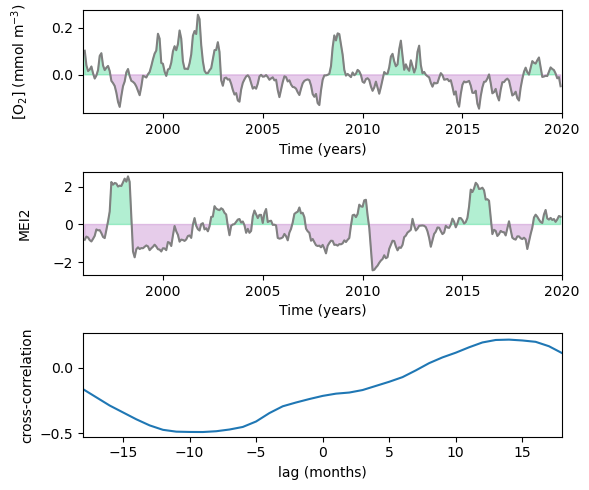

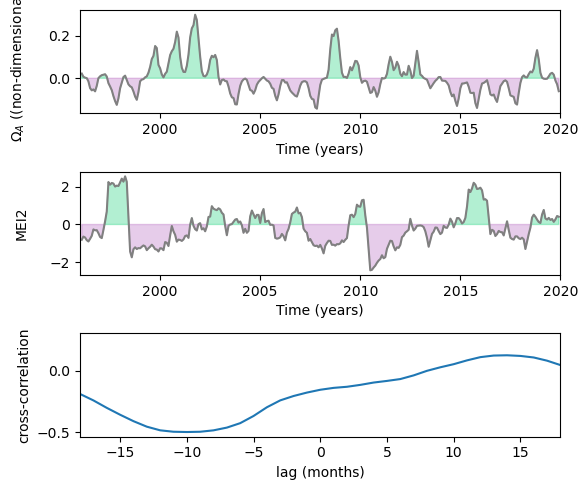

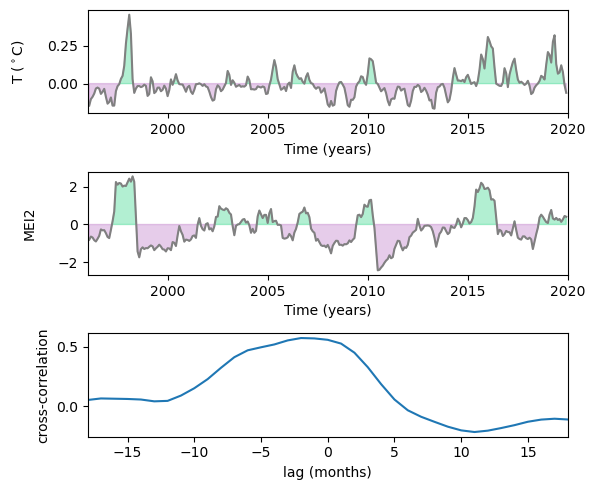

In [41]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    bimon=final_df_cluster0[var]
    print(len(bimon),len(data[1:]) )
    r,lo,hi=plot_correlations(data[1:],bimon, ts[1:], ts[1:],  f"{long_names[var]} ({units[var]})", 'MEI2', 12)
    print(r)
    r_can[idx,0]=r;lo_can[idx,0]=lo;hi_can[idx,0]=hi
#plt.savefig('NEP36_corr_frac_MEI2_omega_canyons.png', format='png', bbox_inches='tight',transparent=False,dpi=500)

O2
##################################
287 287
2.55 0.10982514170916637
max correlation is at lag -1 with r = 0.331189
min correlation is at lag -61 with r = -0.171827
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  0.12250180512981028 0.4849913968447128
cluster 3! 0.3201124673073341
OmegaA
##################################
287 287
2.55 0.44887460593500406
max correlation is at lag -192 with r = 0.239728
min correlation is at lag -8 with r = -0.314165
Probably independent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.3273440150861284 0.04030019971263064
cluster 3! -0.14664898918780586
T
##################################
287 287
2.55 0.25605182010019156
max correlation is at lag -5 with r = 0.364497
min correlation is at lag -60 with r = -0.242078
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  0.13641271700155363 0.501381346156896
cluster 3! 0.3

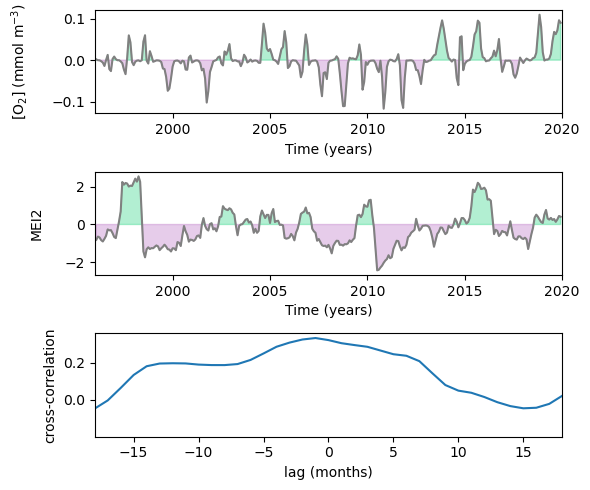

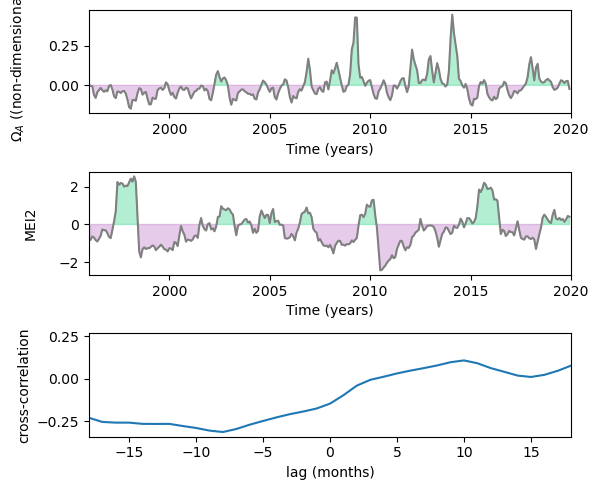

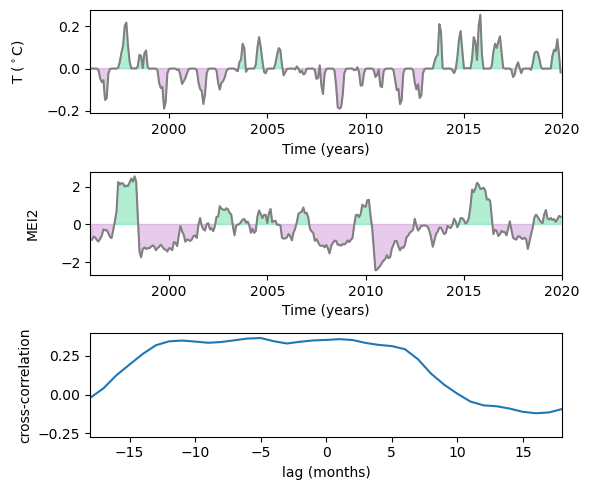

In [42]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    bimon=final_df_cluster3[var]
    print(len(bimon),len(data[1:]) )
    r,lo,hi=plot_correlations(data[1:],bimon, ts[1:], ts[1:],  f"{long_names[var]} ({units[var]})", 'MEI2', 12)
    print('cluster 3!',r)
    r_sh[idx,0]=r;lo_sh[idx,0]=lo;hi_sh[idx,0]=hi
#plt.savefig('NEP36_corr_frac_MEI2_omega_canyons.png', format='png', bbox_inches='tight',transparent=False,dpi=500)

### NPGO

exception could not convert string to float: '</pre>'
exception list index out of range
exception list index out of range
exception list index out of range
exception list index out of range
exception list index out of range
exception could not convert string to float: '</body></html>'
1996-01-15T00:00:00.000000000 2019-12-15T00:00:00.000000000 (288,) (288,)


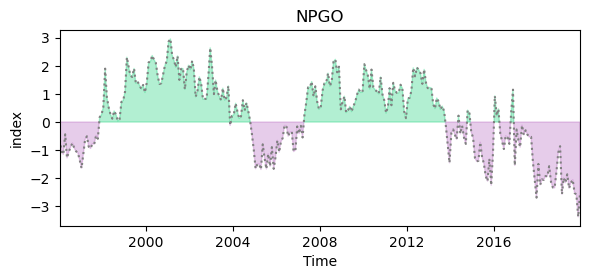

In [43]:
data=[]; count=0
with open('/gpfs/fs7/dfo/hpcmc/pfm/amh001/DATA/Climate-Indices/npgo.txt') as f:
    for line in f.readlines():
        l1=line.strip()
        l2=l1.split()
        count=count+1
        if count>30:
            try:
                #print(l2[0])
                year=int(float(l2[0]))
                #print(year)
                if (year >1995) & (year<2020):
                    #print(year)
                    #count=count+1
                    dat=float(l2[2])
                    #print((dat))

                    data.append(dat)
                    #print(data)
            except Exception as ex:
                print('exception', ex)
data =np.array(data)
dates=np.array(pd.date_range(start="1996-01-15",end="2020-01-01",freq=pd.DateOffset(months=1)))
print(dates[0], dates[-1],np.shape(dates) , np.shape(data))

fig1=plt.figure(figsize=(6,5))
ax1=fig1.add_subplot(212)
plt.title('NPGO')

plt.plot( dates,data, color='0.5', linestyle=':')
ax1.fill_between( dates,data,np.zeros(len(data)),where= data<0,color=color2, alpha=0.3, interpolate=True)
ax1.fill_between( dates,data,np.zeros(len(data)),where= data>0,color=color1, alpha=0.3, interpolate=True)
plt.ylabel('index')
plt.xlabel('Time')
plt.xlim(min(dates), max(dates))
#ax1.fill_betweenx( -depth,np.ones(75)*num*kk,newV,where=V[kk,:]<=0,color=color4, alpha=0.3, interpolate=True)
plt.tight_layout()

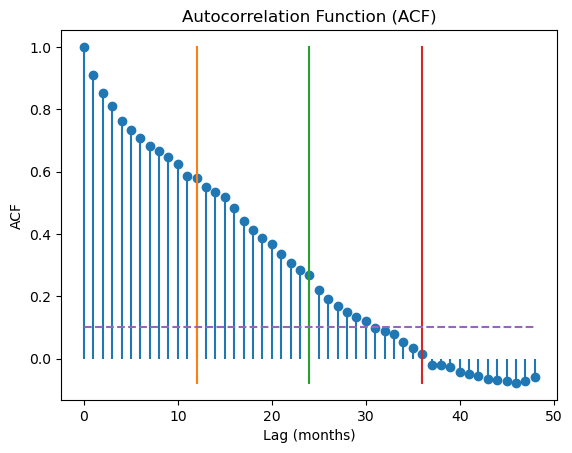

In [44]:

n=48
# Example monthly data for 24 years (288 months)

# Compute autocorrelations
acf_values = acf(data, nlags=n)  # Look at up to 24 lags (2 years)

# Plot autocorrelation
plt.stem(range(n+1), acf_values[:n+1], basefmt=" ")
plt.plot(12*np.ones(n+1), acf_values[:n+1])
plt.plot(24*np.ones(n+1), acf_values[:n+1])
plt.plot(36*np.ones(n+1), acf_values[:n+1])
plt.plot(range(n+1),0.1*np.ones(n+1), '--')

plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag (months)')
plt.ylabel('ACF')
plt.show()

In [45]:

data_frames=[]
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_0_'+var +'_corr.pickle'
        print(name0)
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    X,time=deseason(merged_da[var])
    
    temp_df = pd.DataFrame({
        'time': time,
        var: X
    }).set_index('time')

    data_frames.append(temp_df)
# Combine all DataFrames on the 'time' index
final_df_cluster0 = pd.concat(data_frames, axis=1)


O2
##################################
pickles/Upwelling_0_O2_corr.pickle
pickles/Downwelling_0_O2_corr.pickle
<xarray.DataArray 'O2' (time: 288)> Size: 2kB
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 4B 0.5075
  * time     (time) datetime64[ns] 2kB 1996-01-01 1996-02-01 ... 2019-12-01
OmegaA
##################################
pickles/Upwelling_0_OmegaA_corr.pickle
pickles/Downwelling_0_OmegaA_corr.pickle
<xarray.DataArray 'OmegaA' (time: 288)> Size: 2kB
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 4B 0.5075
  * time     (time) datetime64[ns] 2kB 1996-01-01 1996-02-01 ... 2019-12-01
T
##################################
pickles/Upwelling_0_T_corr.pickle
pickles/Downwelling_0_T_corr.pickle
<xarray.DataArray 'T' (time: 288)> Size: 2kB
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
   

In [46]:

data_frames=[]
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_3_'+var +'_corr.pickle'
        print(name0)
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    X,time=deseason(merged_da[var])
    
    temp_df = pd.DataFrame({
        'time': time,
        var: X
    }).set_index('time')

    data_frames.append(temp_df)
# Combine all DataFrames on the 'time' index
final_df_cluster3 = pd.concat(data_frames, axis=1)


O2
##################################
pickles/Upwelling_3_O2_corr.pickle
pickles/Downwelling_3_O2_corr.pickle
<xarray.DataArray 'O2' (time: 288)> Size: 2kB
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 4B 0.5075
  * time     (time) datetime64[ns] 2kB 1996-01-01 1996-02-01 ... 2019-12-01
OmegaA
##################################
pickles/Upwelling_3_OmegaA_corr.pickle
pickles/Downwelling_3_OmegaA_corr.pickle
<xarray.DataArray 'OmegaA' (time: 288)> Size: 2kB
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 4B 0.5075
  * time     (time) datetime64[ns] 2kB 1996-01-01 1996-02-01 ... 2019-12-01
T
##################################
pickles/Upwelling_3_T_corr.pickle
pickles/Downwelling_3_T_corr.pickle
<xarray.DataArray 'T' (time: 288)> Size: 2kB
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
   

2.9560468 0.15218352054065898
max correlation is at lag 84 with r = 0.163093
min correlation is at lag -1 with r = -0.412630
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.4080637249944627 -0.20276668207239984
2.9560468 0.6390390936523335
max correlation is at lag -121 with r = 0.209914
min correlation is at lag 70 with r = -0.300641
Probably independent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.2632035787122319 0.11415474417357754
2.9560468 0.37693888645536755
max correlation is at lag -188 with r = 0.209431
min correlation is at lag -2 with r = -0.348574
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.43359537950547455 -0.19186898711720876


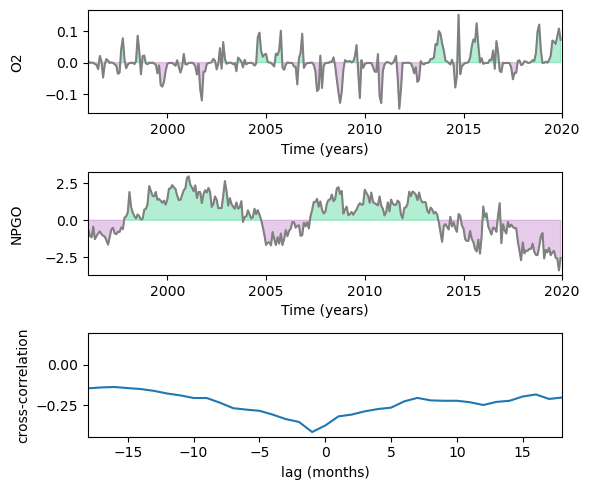

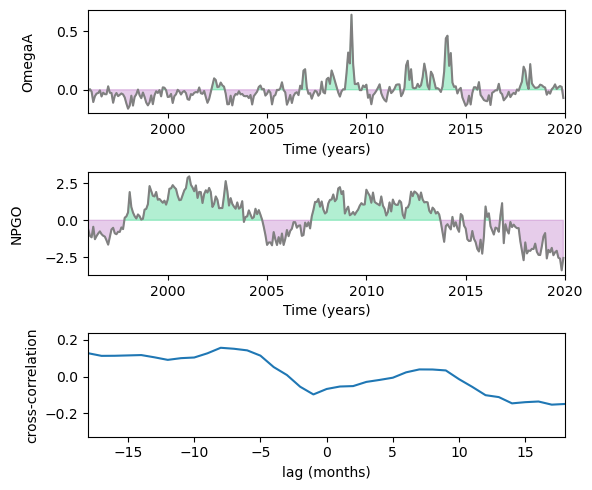

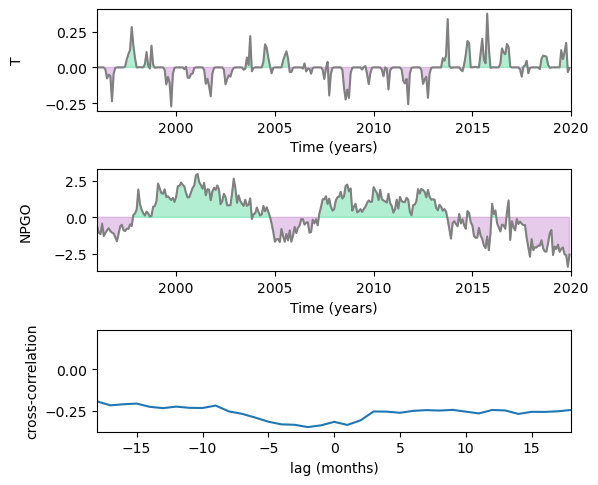

In [47]:
for idx, var in enumerate(timeseries_vars):
    X=final_df_cluster3[var]
    r,lo,hi=plot_correlations(data,X, ts, ts, var, 'NPGO', 36)
    r_sh[idx,2]=r;lo_sh[idx,2]=lo;hi_sh[idx,2]=hi


#ouptut data for Jim

In [48]:
final_df_cluster0[var]

time
1996-01-01   -0.165438
1996-02-01   -0.125763
1996-03-01   -0.078909
1996-04-01   -0.096290
1996-05-01   -0.035947
                ...   
2019-08-01    0.081151
2019-09-01    0.161809
2019-10-01   -0.008717
2019-11-01   -0.011897
2019-12-01   -0.109736
Name: T, Length: 288, dtype: float64

2.9560468 0.32049881360004795
max correlation is at lag -4 with r = 0.365142
min correlation is at lag -57 with r = -0.298200
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  0.12362856970681207 0.5057530445596901
0.2888603643020557
2.9560468 0.33440811118658476
max correlation is at lag -4 with r = 0.403084
min correlation is at lag -55 with r = -0.323570
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  0.17758652527066146 0.5453831561448558
0.36619090022888123
2.9560468 0.5244520366912466
max correlation is at lag -189 with r = 0.207022
min correlation is at lag -5 with r = -0.389506
Probably independent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.3015607146603258 0.10644287238036074
-0.15117320274370705


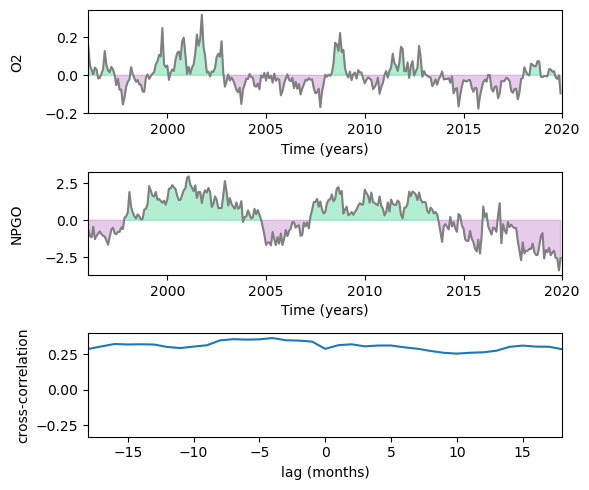

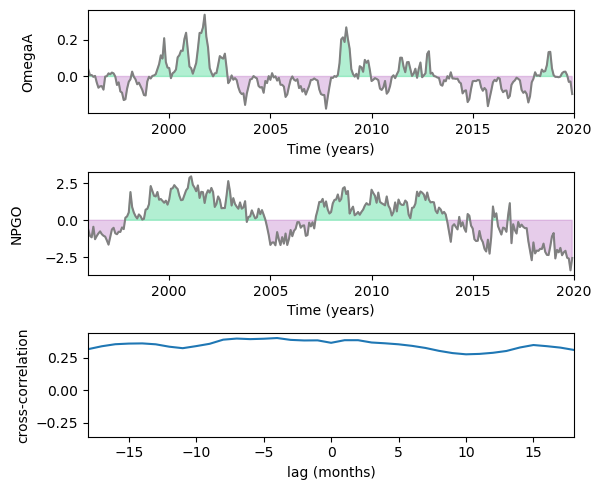

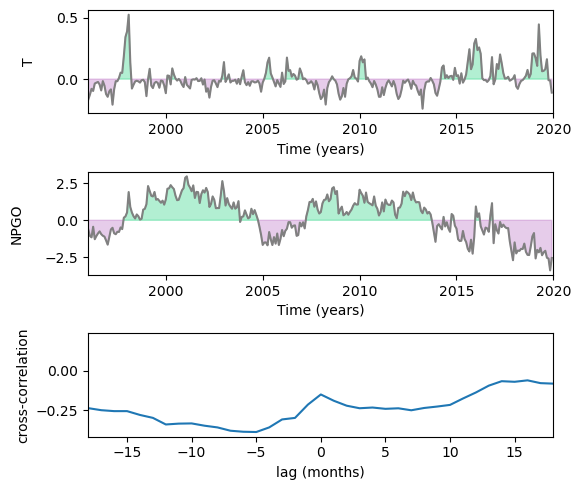

In [49]:
for idx, var in enumerate(timeseries_vars):
    X=final_df_cluster0[var]
    r,lo,hi=plot_correlations(data,X, ts, ts, var, 'NPGO', 36)
    print(r)
    r_can[idx,2]=r;lo_can[idx,2]=lo;hi_can[idx,2]=hi
#plt.savefig('NEP36_corr_frac_NPGOO2.png', format='png', bbox_inches='tight',transparent=False,dpi=500)

In [50]:
print(r_can)
print(r_sh)

[[-0.21618903  0.          0.28886036  0.        ]
 [-0.15541801  0.          0.3661909   0.        ]
 [ 0.55663682  0.         -0.1511732   0.        ]]
[[ 0.32011247  0.         -0.37260331  0.        ]
 [-0.14664899  0.         -0.06684775  0.        ]
 [ 0.35228017  0.         -0.31706476  0.        ]]


### Bakun

In [51]:
data51=[]; count=0
with open('/gpfs/fs7/dfo/hpcmc/pfm/amh001/DATA/Climate-Indices/upind_51.txt') as f:
    for line in f.readlines():
        l1=line.strip()
        l2=l1.split()
        try:
            #print(l2)
            year=int(l2[2])
            #print(year)
            if (year >1995) & (year<2020):
                #print(year)
                count=count+1
                dat=[float(num) for num in l2[3:]]
                #print(len(dat))
                
                data51.extend(dat)
        except:
            print('exception', l2)
data =np.array(data51)
dates=np.array(pd.date_range(start="1996-01-01",end="2020-01-01", freq='M'))
#print(dates)


/tmp/ipykernel_57085/278504744.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates=np.array(pd.date_range(start="1996-01-01",end="2020-01-01", freq='M'))


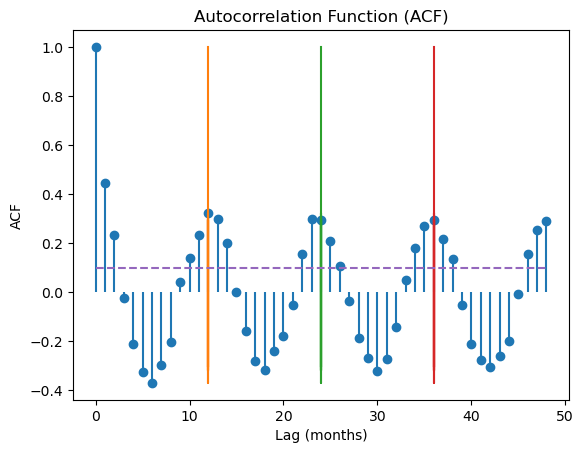

In [52]:

n=48
# Example monthly data for 24 years (288 months)

# Compute autocorrelations
acf_values = acf(data, nlags=n)  # Look at up to 24 lags (2 years)

# Plot autocorrelation
plt.stem(range(n+1), acf_values[:n+1], basefmt=" ")
plt.plot(12*np.ones(n+1), acf_values[:n+1])
plt.plot(24*np.ones(n+1), acf_values[:n+1])
plt.plot(36*np.ones(n+1), acf_values[:n+1])
plt.plot(range(n+1),0.1*np.ones(n+1), '--')

plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag (months)')
plt.ylabel('ACF')
plt.show()

O2
##################################
103.0 0.15218352054065898
max correlation is at lag -1 with r = 0.172046
min correlation is at lag -46 with r = -0.210596
Probably independent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.07231128132480856 0.11562769224876604
OmegaA
##################################
103.0 0.6390390936523335
max correlation is at lag -2 with r = 0.240969
min correlation is at lag -134 with r = -0.220784
Probably independent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.03846648271336993 0.1999401962886334
T
##################################
103.0 0.37693888645536755
max correlation is at lag 41 with r = 0.145328
min correlation is at lag -201 with r = -0.164394
Probably independent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.069867775626335 0.09074997878417915


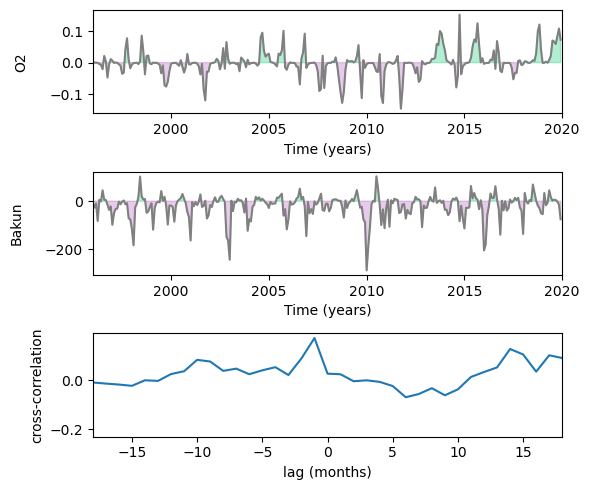

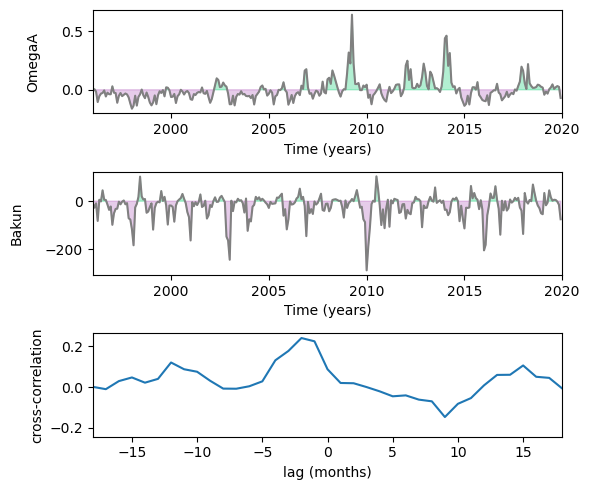

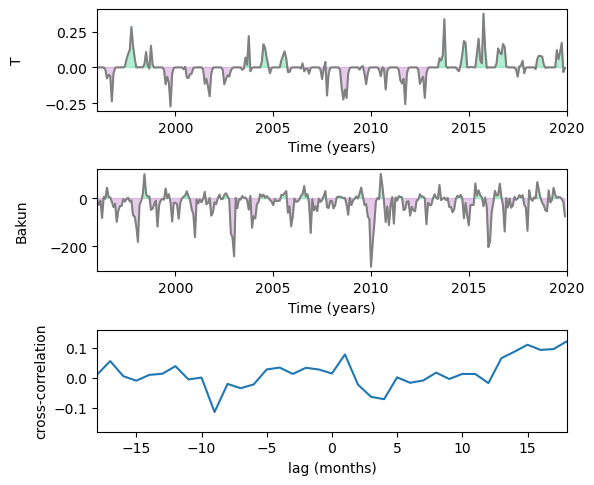

In [53]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    X=final_df_cluster3[var]
    r,lo,hi=plot_correlations(data,X, ts, ts, var, 'Bakun', 12)
    r_sh[idx,3]=r;lo_sh[idx,3]=lo;hi_sh[idx,3]=hi

O2
##################################
103.0 0.32049881360004795
max correlation is at lag -81 with r = 0.113519
min correlation is at lag 15 with r = -0.209185
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  0.01640801763975359 0.15515162847311637
OmegaA
##################################
103.0 0.33440811118658476
max correlation is at lag -58 with r = 0.113127
min correlation is at lag 15 with r = -0.216245
Probably independent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.05207424517203075 0.0850895381578908
T
##################################
103.0 0.5244520366912466
max correlation is at lag -23 with r = 0.146703
min correlation is at lag 0 with r = -0.286949
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.47200416640029513 -0.10048152257130213


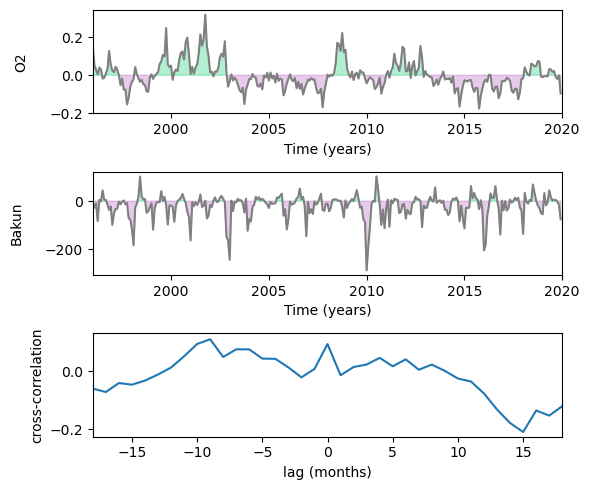

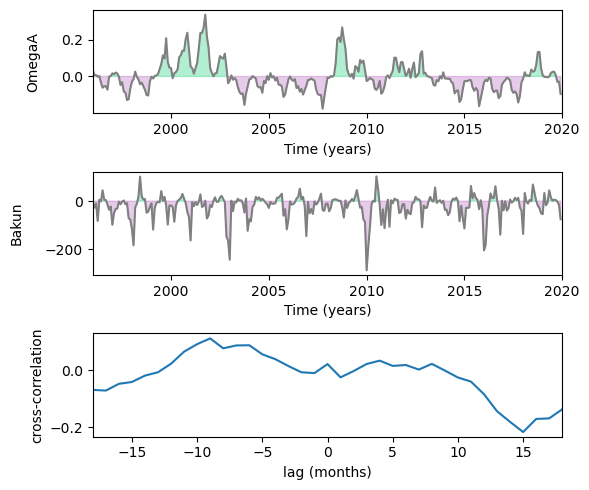

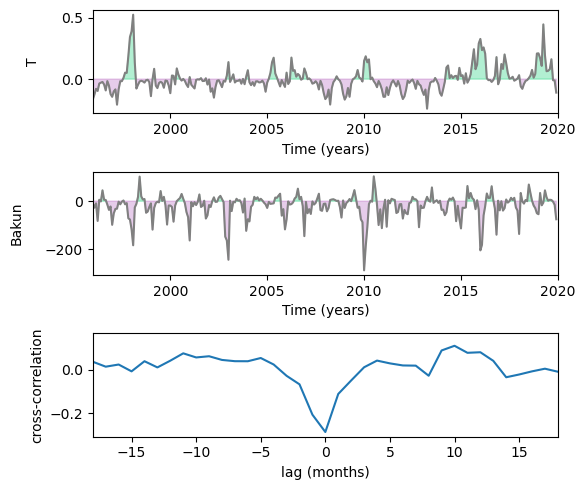

In [54]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    X=final_df_cluster0[var]
    r,lo,hi=plot_correlations(data,X, ts, ts, var, 'Bakun', 12)
    r_can[idx,3]=r;lo_can[idx,3]=lo;hi_can[idx,3]=hi

## PDO

In [55]:
df = pd.read_csv ('/gpfs/fs7/dfo/hpcmc/pfm/amh001/DATA/Climate-Indices/pdo.timeseries.ersstv5.csv')
Time=df.Date.values
PDO=df.PDO.values
TIME = [datetime.datetime.strptime(t0,'%Y-%m-%d') for t0 in Time] 
print(TIME[12*142], TIME[-37], np.shape(TIME), np.shape(PDO))
dates=TIME[12*142:-36]
data=PDO[12*142:-36]

1996-01-01 00:00:00 2019-12-01 00:00:00 (2028,) (2028,)


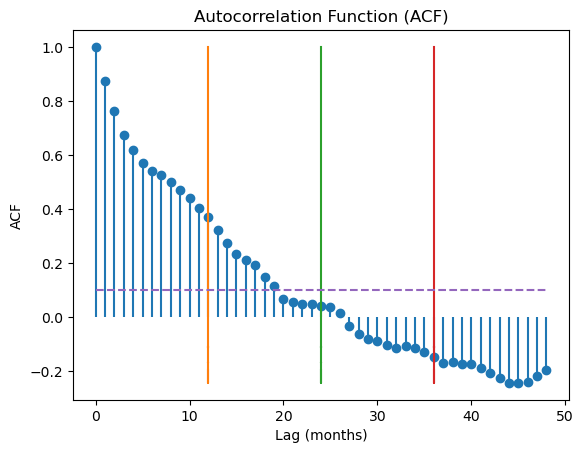

In [56]:

n=48
# Example monthly data for 24 years (288 months)

# Compute autocorrelations
acf_values = acf(data, nlags=n)  # Look at up to 24 lags (2 years)

# Plot autocorrelation
plt.stem(range(n+1), acf_values[:n+1], basefmt=" ")
plt.plot(12*np.ones(n+1), acf_values[:n+1])
plt.plot(24*np.ones(n+1), acf_values[:n+1])
plt.plot(36*np.ones(n+1), acf_values[:n+1])
plt.plot(range(n+1),0.1*np.ones(n+1), '--')

plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag (months)')
plt.ylabel('ACF')
plt.show()

O2
##################################
2.382 0.15218352054065898
max correlation is at lag 9 with r = 0.294942
min correlation is at lag -168 with r = -0.192271
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  0.025814137738588115 0.33759651048548367
OmegaA
##################################
2.382 0.6390390936523335
max correlation is at lag -199 with r = 0.211586
min correlation is at lag -1 with r = -0.357396
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.4652314717223426 -0.15137933383857732
T
##################################
2.382 0.37693888645536755
max correlation is at lag -2 with r = 0.378309
min correlation is at lag -63 with r = -0.240574
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  0.1950725635427159 0.4969961685782137


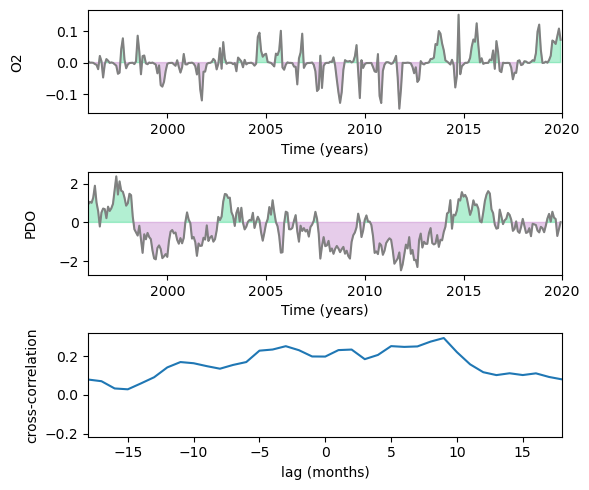

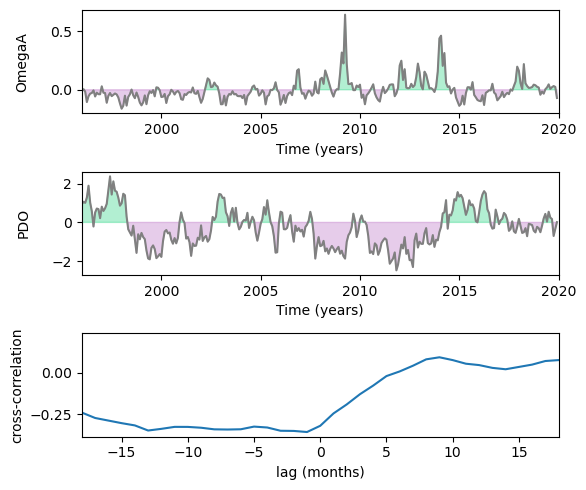

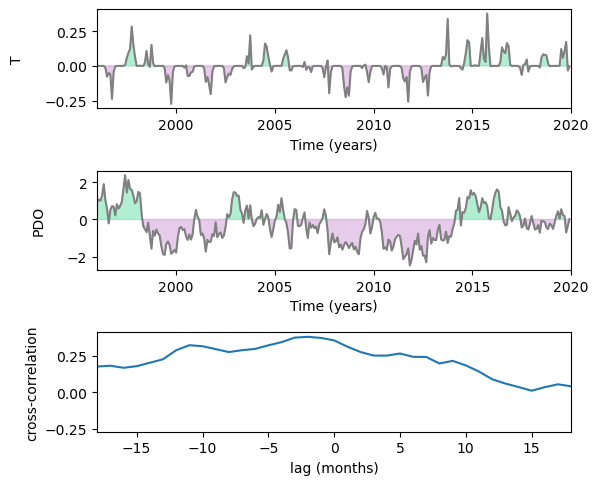

In [57]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    X=final_df_cluster3[var]
    r,lo,hi=plot_correlations(data,X, ts, ts, var, 'PDO', 12)
    r_sh[idx,1]=r;lo_sh[idx,1]=lo;hi_sh[idx,1]=hi

O2
##################################
2.382 0.15218352054065898
max correlation is at lag 9 with r = 0.294942
min correlation is at lag -168 with r = -0.192271
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  0.054132334861618614 0.33507498264869234
OmegaA
##################################
2.382 0.6390390936523335
max correlation is at lag -199 with r = 0.211586
min correlation is at lag -1 with r = -0.357396
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.46036705975346914 -0.15559357002665777
T
##################################
2.382 0.37693888645536755
max correlation is at lag -2 with r = 0.378309
min correlation is at lag -63 with r = -0.240574
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  0.25651193606889605 0.46544065688913033


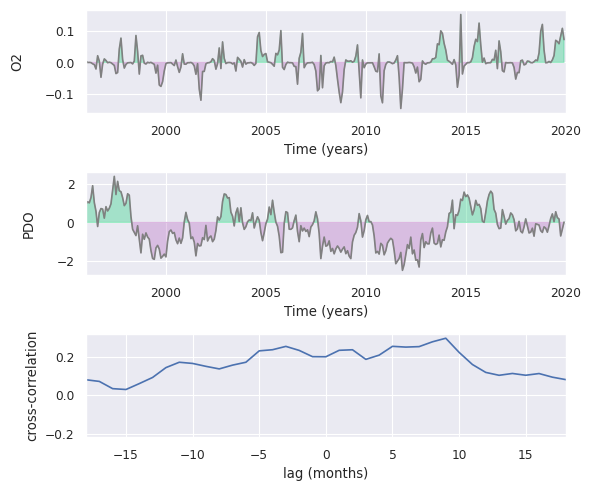

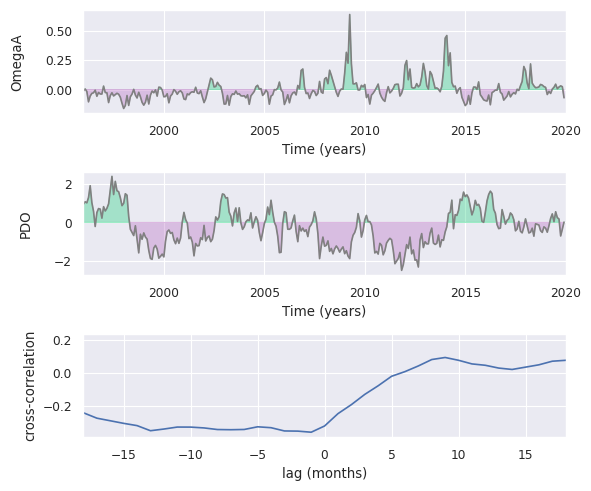

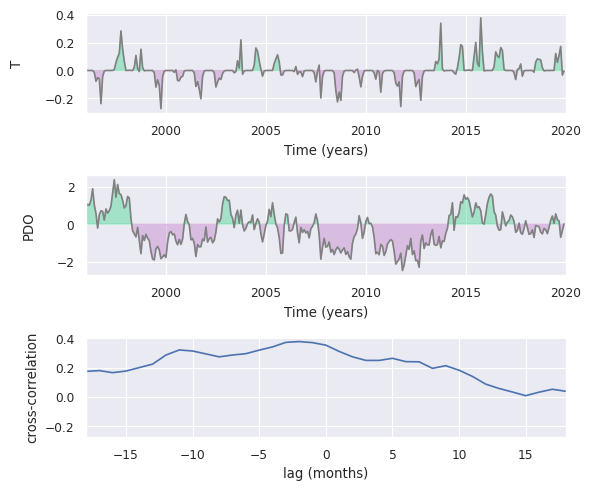

In [68]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    X=final_df_cluster3[var]
    r,lo,hi=plot_correlations(data,X, ts, ts, var, 'PDO', 24)
    r_sh[idx,1]=r;lo_sh[idx,1]=lo;hi_sh[idx,1]=hi

##Canyons

O2
##################################
2.382 0.32049881360004795
max correlation is at lag -51 with r = 0.368930
min correlation is at lag -3 with r = -0.471261
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.5229662259651735 -0.2414012812699701
OmegaA
##################################
2.382 0.33440811118658476
max correlation is at lag -51 with r = 0.414839
min correlation is at lag -4 with r = -0.494414
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  -0.48207129227351175 -0.21844887787271297
T
##################################
2.382 0.5244520366912466
max correlation is at lag 0 with r = 0.396811
min correlation is at lag -94 with r = -0.213698
Probably dependent based on pearson
With 95.0 % confidence, the time series correlation is between  0.33172732192178217 0.5947837222160907


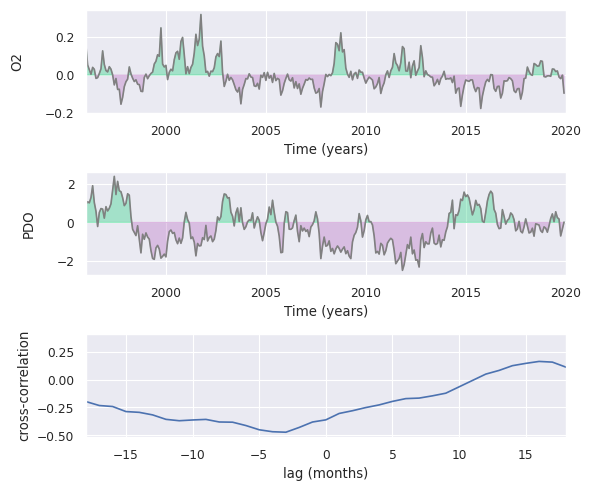

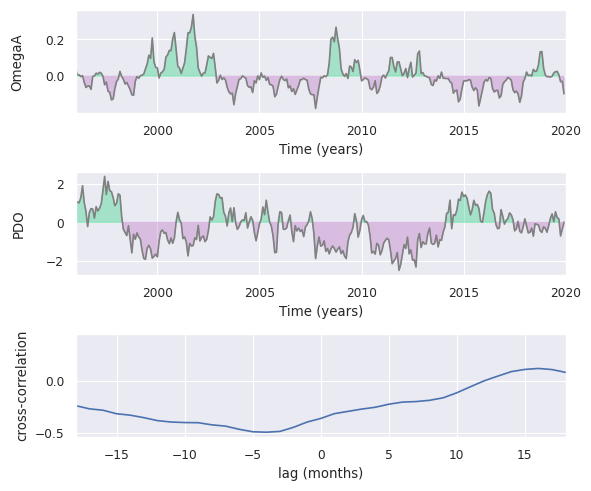

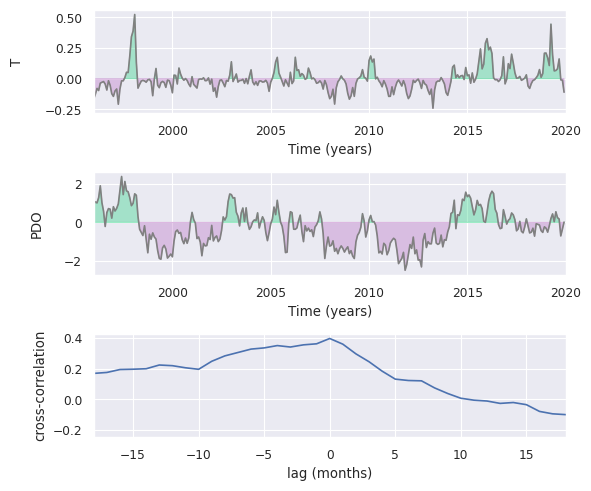

In [69]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    X=final_df_cluster0[var]
    r,lo,hi=plot_correlations(data,X, ts, ts, var, 'PDO', 24)
    r_can[idx,1]=r;lo_can[idx,1]=lo;hi_can[idx,1]=hi

## HEATMAP Shallows


In [59]:
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#mymap=sns.choose_diverging_palette(as_cmap=False)
r_can
r_sh

array([[ 0.32011247,  0.1988924 , -0.37260331,  0.02700662],
       [-0.14664899, -0.31960242, -0.06684775,  0.08750151],
       [ 0.35228017,  0.35388471, -0.31706476,  0.0145682 ]])

[[ 0.32011247  0.1988924  -0.37260331         nan]
 [        nan -0.31960242         nan         nan]
 [ 0.35228017  0.35388471 -0.31706476         nan]]


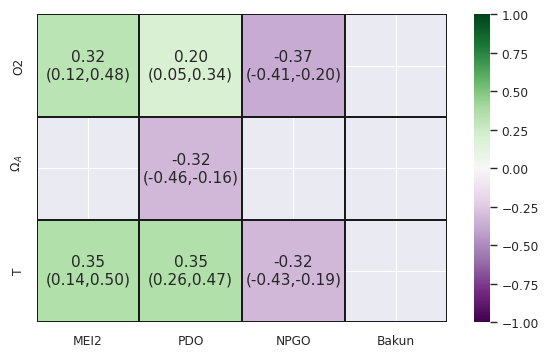

In [70]:
# combining text with values
formatted_text = (np.asarray(["{0:.2f}\n({1:.2f},{2:.2f})".format(
    B0,B1, B2) for B0,B1, B2 in zip(r_sh.flatten(), lo_sh.flatten(), hi_sh.flatten())])).reshape(3, 4)

cols=['MEI2', 'PDO', 'NPGO', 'Bakun']
rows=['O2','   $\Omega_A$', 'T']

R=r_sh.copy()


#remove values
IND = (hi_sh * lo_sh <0)

#IND=((hi_sh+lo_sh)<(np.abs(hi_sh)+np.abs(lo_sh)))
R[IND]=np.nan
figprops = dict(figsize=(7, 4))
fig = plt.figure(**figprops)
ax1 = fig.add_subplot(111)
print(R)
hm = sns.heatmap(R,
                 cbar=True,
                 annot=formatted_text,
                 square=True,
                 fmt='',
                 annot_kws={'size': 11},
                 cmap='PRGn',                 
                 yticklabels=rows,
                 xticklabels=cols, 
                linewidths=0.25, vmin=-1, vmax=1.0, linecolor='k')
#plt.savefig('Climate_indices_nobakun.jpg', format='jpg', bbox_inches='tight',transparent=False,dpi=150)

In [61]:
lo_sh

array([[ 0.12250181,  0.02581414, -0.40806372, -0.07231128],
       [-0.32734402, -0.46523147, -0.26320358, -0.03846648],
       [ 0.13641272,  0.19507256, -0.43359538, -0.06986778]])

In [62]:
r_sh

array([[ 0.32011247,  0.1988924 , -0.37260331,  0.02700662],
       [-0.14664899, -0.31960242, -0.06684775,  0.08750151],
       [ 0.35228017,  0.35388471, -0.31706476,  0.0145682 ]])

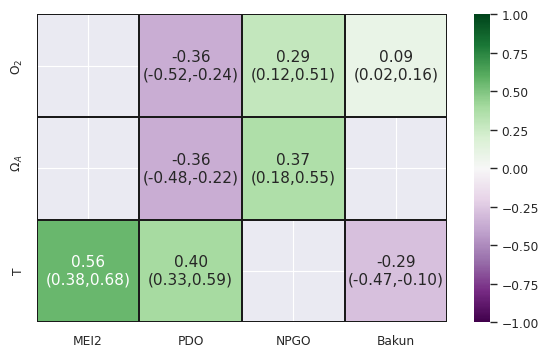

In [71]:
# combining text with values
formatted_text = (np.asarray(["{0:.2f}\n({1:.2f},{2:.2f})".format(
    B0,B1, B2) for B0,B1, B2 in zip(r_can.flatten(), lo_can.flatten(), hi_can.flatten())])).reshape(3, 4)

cols=['MEI2', 'PDO', 'NPGO', 'Bakun']
rows=['$\mathrm{O}_2$','   $\Omega_A$', 'T']
R=r_can.copy()

#remove values
IND = (hi_can * lo_can <0)

#IND=((hi_can+lo_can)<(np.abs(hi_can)+np.abs(lo_can)))
R[IND]=np.nan

figprops = dict(figsize=(7, 4))
fig = plt.figure(**figprops)
ax1 = fig.add_subplot(111)

hm = sns.heatmap(R,
                 cbar=True,
                 annot=formatted_text,
                 square=True,
                 fmt='',
                 annot_kws={'size': 11},
                 cmap='PRGn',                 
                 yticklabels=rows,
                 xticklabels=cols, 
                linewidths=0.25, 
                 vmin=-1, vmax=1.0,
                linecolor='k')
#plt.savefig('Climate_indices_nobakun.jpg', format='jpg', bbox_inches='tight',transparent=False,dpi=150)

In [64]:
lo_can

array([[-0.41828371, -0.53046493,  0.12362857,  0.01640802],
       [-0.36734347, -0.4957206 ,  0.17758653, -0.05207425],
       [ 0.38092945,  0.26273504, -0.30156071, -0.47200417]])

In [65]:
hi_can

array([[ 0.03940003, -0.20131533,  0.50575304,  0.15515163],
       [ 0.09057704, -0.20549241,  0.54538316,  0.08508954],
       [ 0.67520371,  0.57301137,  0.10644287, -0.10048152]])

[[ 0.32011247  0.1988924  -0.37260331         nan]
 [        nan -0.31960242         nan         nan]
 [ 0.35228017  0.35388471 -0.31706476         nan]]


/tmp/ipykernel_57085/3866770015.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


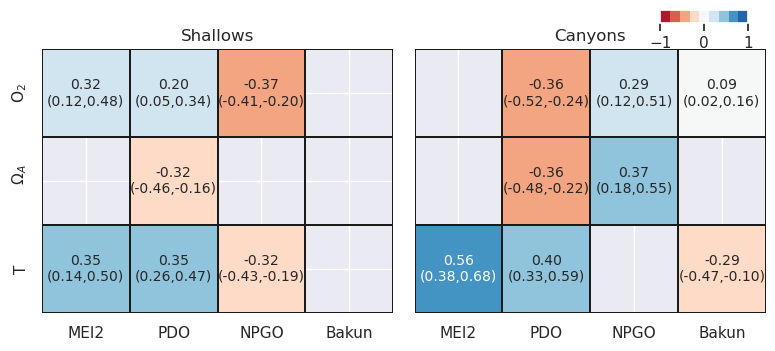

In [72]:
#import matplotlib.cm as cm
#from matplotlib import colors
#import colorcet as cc
sns.set()
cmap1 = mymap
# combining text with values
formatted_text = (np.asarray(["{0:.2f}\n({1:.2f},{2:.2f})".format(
    B0,B1, B2) for B0,B1, B2 in zip(r_sh.flatten(), lo_sh.flatten(), hi_sh.flatten())])).reshape(3, 4)

cols=['MEI2', 'PDO', 'NPGO', 'Bakun']
rows=['$\mathrm{O}_2$','   $\Omega_A$', 'T']

R=r_sh.copy()


#remove values
IND = (hi_sh * lo_sh <0)

#IND=((hi_sh+lo_sh)<(np.abs(hi_sh)+np.abs(lo_sh)))
R[IND]=np.nan
figprops = dict(figsize=(8, 5))
fig = plt.figure(**figprops)
ax1 = fig.add_subplot(121)
print(R)
hm = sns.heatmap(R,
                 cbar=False,
                 annot=formatted_text,
                    cbar_kws={'location': 'bottom', 'pad': 0.1},

                 square=True,
                 fmt='',
                 annot_kws={'size': 10},
                 cmap=cmap1,                 
                 yticklabels=rows,
                 xticklabels=cols, 
                linewidths=0.25, vmin=-1, vmax=1, linecolor='k')
plt.title('Shallows')

# combining text with values
formatted_text = (np.asarray(["{0:.2f}\n({1:.2f},{2:.2f})".format(
    B0,B1, B2) for B0,B1, B2 in zip(r_can.flatten(), lo_can.flatten(), hi_can.flatten())])).reshape(3, 4)

cols=['MEI2', 'PDO', 'NPGO', 'Bakun']
R=r_can.copy()

#remove values
IND = (hi_can * lo_can <0)

R[IND]=np.nan

ax2 = fig.add_subplot(122)
hm = sns.heatmap(R,
                 cbar=False,
                cbar_kws={'location': 'bottom', 'pad': 0.1},
                 annot=formatted_text,
                 square=True,
                 fmt='',
                 annot_kws={'size': 10},
                 cmap=cmap1,                 
                 yticklabels=[],
                 xticklabels=cols, 
                linewidths=0.25, 
                 vmin=-1, vmax=1,
                linecolor='k')
plt.title('Canyons')
axins = inset_axes(ax2,
                       width="100%",  # width = 5% of parent_bbox width
                       height="50%",  # height : 50%
                       loc='lower left',
                       bbox_to_anchor=(0.7, 1.1, 0.25, 0.1),
                       bbox_transform=ax2.transAxes,
                       borderpad=0,
                       )
#cbar=fig.colorbar(cs, cax=axins)
fig.colorbar(ax2.get_children()[0], cax=axins, orientation="horizontal")
plt.tight_layout()
#plt.savefig('NEP36_corr_frac.jpg', format='jpg', bbox_inches='tight',transparent=False,dpi=500)

[[ 0.32011247  0.1988924  -0.37260331         nan]
 [        nan -0.31960242         nan         nan]
 [ 0.35228017  0.35388471 -0.31706476         nan]]


/tmp/ipykernel_57085/2251265006.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


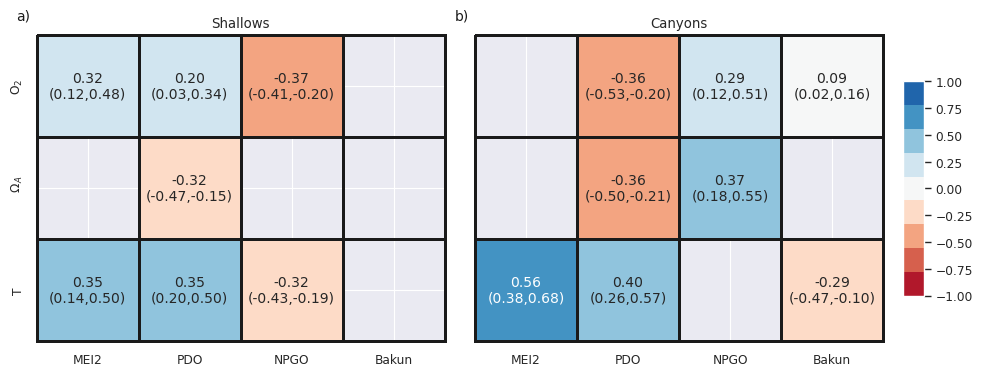

In [67]:
#import matplotlib.cm as cm
#from matplotlib import colors
#import colorcet as cc
#cmap1 = 'RdBu'
# combining text with values
sns.set('paper')
formatted_text = (np.asarray(["{0:.2f}\n({1:.2f},{2:.2f})".format(
    B0,B1, B2) for B0,B1, B2 in zip(r_sh.flatten(), lo_sh.flatten(), hi_sh.flatten())])).reshape(3, 4)

cols=['MEI2', 'PDO', 'NPGO', 'Bakun']
rows=['$\mathrm{O}_2$','   $\Omega_A$', 'T']

R=r_sh.copy()



lw=2
#remove values
IND = (hi_sh * lo_sh <0)

#IND=((hi_sh+lo_sh)<(np.abs(hi_sh)+np.abs(lo_sh)))
R[IND]=np.nan
figprops = dict(figsize=(Hf, Wf))
fig = plt.figure(**figprops)
ax1 = fig.add_subplot(121)
print(R)
hm = sns.heatmap(R,
                 cbar=False,
                 annot=formatted_text,
                    cbar_kws={'location': 'bottom', 'pad': 0.1},

                 square=True,
                 fmt='',
                 annot_kws={'size': 10},
                 cmap=mymap,                 
                 yticklabels=rows,
                 xticklabels=cols, 
                linewidths=lw, vmin=-1, vmax=1, linecolor='k', clip_on=False)
plt.title('Shallows')
ax1.text(-0.05, 1.05,'a)' , transform=ax1.transAxes, color='.1',size=10)


#################################
# combining text with values
formatted_text = (np.asarray(["{0:.2f}\n({1:.2f},{2:.2f})".format(
    B0,B1, B2) for B0,B1, B2 in zip(r_can.flatten(), lo_can.flatten(), hi_can.flatten())])).reshape(3, 4)

cols=['MEI2', 'PDO', 'NPGO', 'Bakun']
R=r_can.copy()

#remove values
IND = (hi_can * lo_can <0)

R[IND]=np.nan


ax2 = fig.add_subplot(122)
hm = sns.heatmap(R,
                 cbar=False,
                cbar_kws={'location': 'bottom', 'pad': 0.1},
                 annot=formatted_text,
                 square=True,
                 fmt='',
                 annot_kws={'size': 10},
                 cmap=cmap1,                 
                 yticklabels=[],
                 xticklabels=cols, 
                linewidths=lw, 
                 vmin=-1, vmax=1,
                linecolor='k', clip_on=False)
plt.title('Canyons')
axins = inset_axes(ax2,
                       width="50%",  # width = 5% of parent_bbox width
                       height="100%",  # height : 50%
                       loc='lower left',
                       bbox_to_anchor=(1.05, 0.15, 0.1, 0.7),
                       bbox_transform=ax2.transAxes,
                       borderpad=0,
                       )
ax2.text(-0.05, 1.05,'b)' , transform=ax2.transAxes, color='.1',size=10)

#cbar=fig.colorbar(cs, cax=axins)
fig.colorbar(ax2.get_children()[0], cax=axins, orientation="vertical")
plt.tight_layout()
plt.savefig('../Figures/NEP36_corr_frac.png', format='png', bbox_inches='tight',transparent=False,dpi=500)